In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_palette("husl")

import warnings
warnings.simplefilter('ignore')

### 1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

In [2]:
X, y = load_iris(return_X_y=True)
X = X[:, :2]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

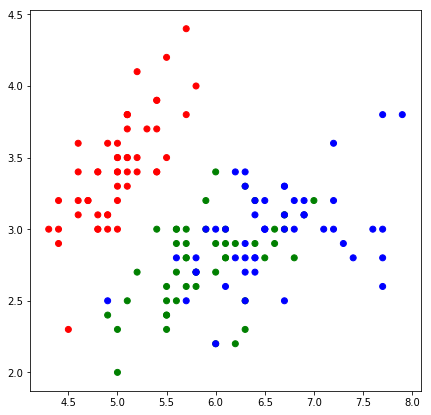

In [3]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

In [4]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [5]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1 / d[0] ** 2
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [6]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [7]:
k = 6

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 6: 0.833


In [8]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

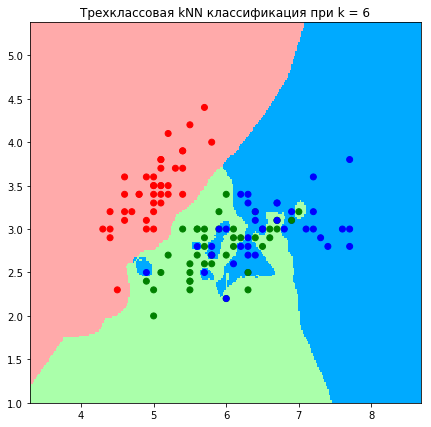

In [9]:
get_graph(X_train, y_train, k)

### 2*. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить 
### график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [10]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, random_state=42)

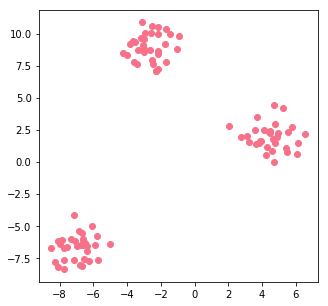

In [11]:
plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1])

In [12]:
def ams_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.mean(distance)

In [13]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [ams_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к классу, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
            mean_distance = np.mean(min(distances))
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения с новыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if abs(np.sum((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем  
        if optimal:
            break
    
    return old_centroids, classes, mean_distance

In [18]:
max_iterations = 5
min_distance = 1e-3

In [19]:
k_array = np.arange(1,10)

In [20]:
mean_aqu_dist = []
for k in k_array:
    centroids, clusters, mean_distance = kmeans(X, k, max_iterations, min_distance)
    mean_aqu_dist.append(mean_distance)

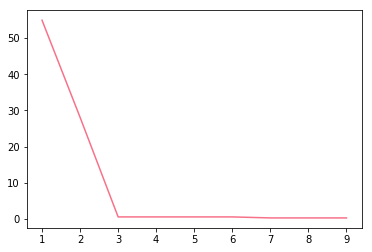

In [21]:
plt.plot(k_array, mean_aqu_dist)